파이썬 머신러닝 완벽가이드 ch4. 9 ~ 10 pg. 267 ~ 295

---



##04-09. 분류 실습 - 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해보자. 산탄데르 고객 만족 예측 분석은
370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것이다. 클래스 레이블 명은 TARGET이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다. 산탄데르 은행이
캐글에 경연을 의뢰한 데이터로서 피처 이름은 모두 익명 처리돼 이름만을 가지고 어떤 속성인지는 추정할 수 없다.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv('/content/drive/MyDrive/ESAA/dataset/train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 371개의 피처 중 111개의 피처가 float형, 260개의 피처가 int형. Null 값은 없음.
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
# 대부분이 만족, 불만족인 고객은 4%
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt/total_cnt))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
# var3 칼럼에서 -999999값이 116개임. NaN이나 특정 예외 값을 -999999로 변환한 것으로 보임.
cust_df.var3.value_counts()

,count
var3,
2,74165
8,138
-999999,116
9,110
3,108
...,...
231,1
188,1
168,1


In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {0}, 테스트 세트 Shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

**XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

- 사이킷런 래퍼인 XGBClassifier 기반으로 학습 수행
-  참고로, XGBoost가 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 많이 걸림. 앙상블 계열 알고리즘은은 과적합이나 잡음에 뛰어난 알고리즘이기 때문에 하이퍼 파라미터 튜닝으로 성능수치 개선이 급격하게 되진 않음.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156, early_stopping_rounds=100, eval_metric='auc')

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

In [ ]:
# HyperOpt을 이용해서 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝 수행.
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_tree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색하는 검색공간 설정.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_tree': hp.uniform('colsample_tree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [ ]:
# 3 Fold 교차검증을 이용해 평균 ROC-AUC값을 반환하되 -1을 곱해주어 최대 ROC-AUC값이 최소 반환값이 되도록 목적함수 설정.
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  # n_estimators는 100, early stopping은 30회로 설정
  xgb_clf = XGBClassifier(n_estimators=100,
                          early_stopping_rounds=30,
                          eval_metric='auc',
                          max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          colsample_tree=search_space['colsample_tree'],
                          learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

    # 3개의 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정
            trials=trials,
            rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.83955	validation_1-auc:0.80308
[1]	validation_0-auc:0.84456	validation_1-auc:0.80988
[2]	validation_0-auc:0.84717	validation_1-auc:0.81190
[3]	validation_0-auc:0.84824	validation_1-auc:0.81207
[4]	validation_0-auc:0.85141	validation_1-auc:0.81583
[5]	validation_0-auc:0.85266	validation_1-auc:0.81621
[6]	validation_0-auc:0.85383	validation_1-auc:0.81740
[7]	validation_0-auc:0.85485	validation_1-auc:0.81776
[8]	validation_0-auc:0.85642	validation_1-auc:0.81956
[9]	validation_0-auc:0.85680	validation_1-auc:0.82037
[10]	validation_0-auc:0.85789	validation_1-auc:0.82109
[11]	validation_0-auc:0.85873	validation_1-auc:0.82170
[12]	validation_0-auc:0.86008	validation_1-auc:0.82296
[13]	validation_0-auc:0.86128	validation_1-auc:0.82378
[14]	validation_0-auc:0.86264	validation_1-auc:0.82388
[15]	validation_0-auc:0.86350	validation_1-auc:0.82514
[16]	validation_0-auc:0.86447	validation_1-auc:0.82569
[17]	validation_0-auc:0.86500	validation_1-auc:0.82594
[18]	validation_0-au

In [ ]:
# 도출된 최적의 하이퍼 파라미터를 기반으로 XGBClassifier을 재학습시키고, 테스트 데이터 세트에서 ROC-AUC 측정
# n_estimator는 500으로 증가, early_stopping_rounds는 100, evaluation metric은 auc로 설정.
xgb_clf = XGBClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric='auc',
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        learning_rate=round(best['learning_rate'], 5),
                        colsample_tree=round(best['colsample_tree'], 5)
                        )

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82902	validation_1-auc:0.81059
[1]	validation_0-auc:0.83265	validation_1-auc:0.81356
[2]	validation_0-auc:0.83571	validation_1-auc:0.81568
[3]	validation_0-auc:0.83834	validation_1-auc:0.81980
[4]	validation_0-auc:0.84040	validation_1-auc:0.82209
[5]	validation_0-auc:0.84216	validation_1-auc:0.82303
[6]	validation_0-auc:0.84432	validation_1-auc:0.82392
[7]	validation_0-auc:0.84617	validation_1-auc:0.82476
[8]	validation_0-auc:0.84772	validation_1-auc:0.82630
[9]	validation_0-auc:0.84881	validation_1-auc:0.82697
[10]	validation_0-auc:0.85009	validation_1-auc:0.82792
[11]	validation_0-auc:0.85080	validation_1-auc:0.82927
[12]	validation_0-auc:0.85153	validation_1-auc:0.82990
[13]	validation_0-auc:0.85317	validation_1-auc:0.83204
[14]	validation_0-auc:0.85405	validation_1-auc:0.83238
[15]	validation_0-auc:0.85523	validation_1-auc:0.83342
[16]	validation_0-auc:0.85583	validation_1-auc:0.83369
[17]	validation_0-auc:0.85675	validation_1-auc:0.83350
[18]	validation_0-au

ROC-AUC값이 0.8417에서 하이퍼 파라미터 튜닝 이후 0.8445로 개선됨을 알 수 있다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

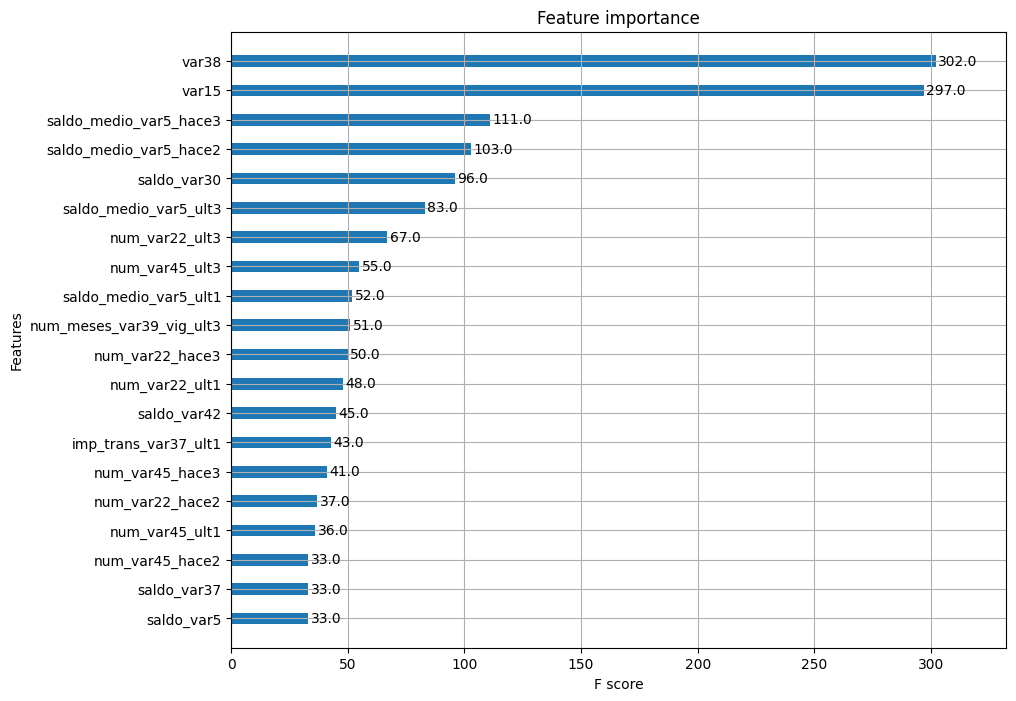

In [ ]:
# 튜닝된 모델에서 각 피처의 중요도를 xgboost 모듈의 plot_importance() 메서드로 나타내기
# var38, var15 피처가 XGBoost의 예측 성능을 좌우하는 중요한 피처로 보임
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

**LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

- 사이킷런 래퍼인 LGBMClassifier 기반으로 학습 수행
- LightGBM은 XGBoost에 비해 학습 시간이 상대적으로 빠름

In [ ]:
pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric='auc')

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's binary_logloss: 0.15523	valid_1's binary_logloss: 0.15774
[2]	training's binary_logloss: 0.149581	valid_1's binary_logloss: 0.153275
[3]	training's binary_logloss: 0.145416	valid_1's binary_logloss: 0.149999
[4]	training's binary_logloss: 0.14212	valid_1's binary_logloss: 0.147524
[5]	training's binary_logloss: 0.139438	valid_1's binary_logloss: 0.145464
[6]	training's binary_logloss: 0.137254	valid_1's binary_logloss: 0.143973
[7]	training's binary_logloss: 0.1354	valid_1's binary_logloss: 0.142746
[8]	training's binary_logloss: 0.133561	valid_1's binary_logloss: 0.141592
[9]	training's binary_logloss: 0.132058	valid_1's binary_logloss: 0.140633
[10]	training's binary_logloss: 0.13065	valid_1's binary_logloss: 0.139756
[11]	training's binary_logloss: 0.129493	valid_1's binary_logloss: 0.139069
[12]	training's binary_logloss: 0.128398	valid_1's binary_logloss: 0.138559
[13]	training's binary_logloss: 0.127345	valid_1's binary_logloss: 0.138135
[14]	training's binary_logl

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [ ]:
# 목적함수 생성
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100, early_stopping_rounds=30, eval_metric='auc',
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['subsample'],
                            learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행.
    lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

    # 3개의 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals에 지정된 횟수만큼 반복 후 목적 함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수 지정
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	training's binary_logloss: 0.162294	valid_1's binary_logloss: 0.163544
[2]	training's binary_logloss: 0.160269	valid_1's binary_logloss: 0.161866
[3]	training's binary_logloss: 0.158478	valid_1's binary_logloss: 0.16038
[4]	training's binary_logloss: 0.156852	valid_1's binary_logloss: 0.159053
[5]	training's binary_logloss: 0.155354	valid_1's binary_logloss: 0.157793
[6]	training's binary_logloss: 0.153966	valid_1's binary_logloss: 0.156635
[7]	training's binary_logloss: 0.152691	valid_1's binary_logloss: 0.155585
[8]	training's binary_logloss: 0.151499	valid_1's binary_logloss: 0.154617
[9]	training's binary_logloss: 0.150393	valid_1's binary_logloss: 0.153725
[10]	training's binary_logloss: 0.149346	valid_1's binary_logloss: 0.152878
[11]	training's binary_logloss: 0.148364	valid_1's binary_loglos

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric='auc',
                          num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'], 5))

lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	training's binary_logloss: 0.152334	valid_1's binary_logloss: 0.155342
[2]	training's binary_logloss: 0.146166	valid_1's binary_logloss: 0.150222
[3]	training's binary_logloss: 0.141868	valid_1's binary_logloss: 0.146771
[4]	training's binary_logloss: 0.138601	valid_1's binary_logloss: 0.144294
[5]	training's binary_logloss: 0.136011	valid_1's binary_logloss: 0.142454
[6]	training's binary_logloss: 0.133921	valid_1's binary_logloss: 0.141014
[7]	training's binary_logloss: 0.132142	valid_1's binary_logloss: 0.139881
[8]	training's binary_logloss: 0.13056	valid_1's binary_logloss: 0.138871
[9]	training's binary_logloss: 0.129277	valid_1's binary_logloss: 0.138118
[10]	training's binary_logloss: 0.128111	valid_1's binary_logloss: 0.137554
[11]	training's binary_logloss: 0.127077	valid_1's binary_log

ROC-AUC가 하이퍼 파라미터 튜닝으로 0.8384에서 0.8394로 개선됨을 알 수 있다

##04-10. 분류 실습 - 캐글 신용카드 사기 검출

해당 데이터 세트의 레이블인 Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미. 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션으로, 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있음. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴보자!



#### - 언더 샘플링과 오버 샘플링의 이해

이상 레이블(1)을 가지는 데이터 건수가 정상 레이블(0)을 가진 데이터 건수에 비해 너무 적은 불균형한 분포 데이터 세트에서 일방적으로 정상 레이블로 치우친 학습을 수행하게 되어 제대로 된 이상 데이터 검출이 어려움 적절한 학습 데이터를 확보하기 위해 언더 샘플링 또는 오버 샘플링을 수행함

- 언더 샘플링(Undersampling) :
   - 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소시키는 방식
   - 너무 많이 감소시켜서 오히려 데이터가 많은 레이블을 제대로 학습하지 못하는 문제가 발생할 수 있다는 단점
- 오버 샘플링(Oversampling) :
   - 반대로, 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식시키는 방식
   - 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfitting)이 되기 때문에 원본 데이터의 피처 값들을 약간 변경하여 증식해야 함
   - 반드시 학습 데이터만 오버 샘플링해야 함. 검증 데이터나 테스트 데이터를 오버 샘플링할 경우 결국 원본 데이터 세트가 아닌 데이터로 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없으므로
   - SMOTE 방법이 대표적! SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식



In [ ]:
# SMOTE를 구현하는 imbalanced-learn 파이썬 패키지를 설치
!pip install imbalanced-learn

**데이터 일차 가공 및 모델 학습/예측/평가**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/ESAA/dataset/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
# 결측치는 없고, Class 레이블만 int형이고 나머지 피처들은 모두 float형.
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수 생성
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할.
  # stratify=y_target으로 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도가 동일하도록 함.
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [ ]:
# get_clf_eval() 함수로 평가 수행

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8598, 재현율: 0.6216, F1: 0.7216, AUC:0.9738


In [ ]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아 학습/예측/평가를 수행하는 함수 생성
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


**데이터 분포도 변환 후 모델 학습/예측/평가**

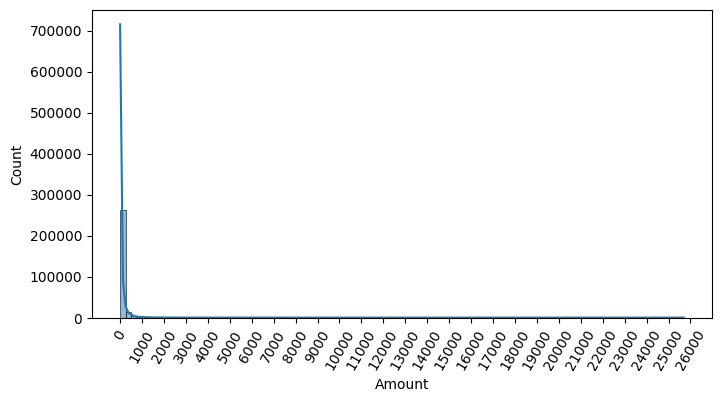

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

**데이터 분포도 변환 후 모델 학습/예측/평가 - 정규분포 형태로 변환**
   - sklearn.preprocessing의 StandardScaler API 이용

In [ ]:
from sklearn.preprocessing import StandardScaler

# 사이킷런 StandardScaler를 이용해 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame의 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
# Amount 피처를 표준정규분포 형태로 변환한 후의 로지스틱 회귀와 LightGBM 모델 예측 성능
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1: 0.7294, AUC:0.9706
### LightGBM 예측 성능###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9779


**데이터 분포도 변환 후 모델 학습/예측/평가 - 로그 변환**
   - 심하게 왜곡되어 있는 데이터 분포도를 상당 수준 개선시켜줌.
   - 넘파이의 log1p( )함수 이용

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1: 0.7120, AUC:0.9734
###LightGBM 예측 성능###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9796


####이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 데이터(Outlier) : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터. 머신러닝 모델의 성능에 영향을 주기 쉽기 때문에 제거한 뒤 모델을 다시 평가할 필요가 있음


<Axes: >

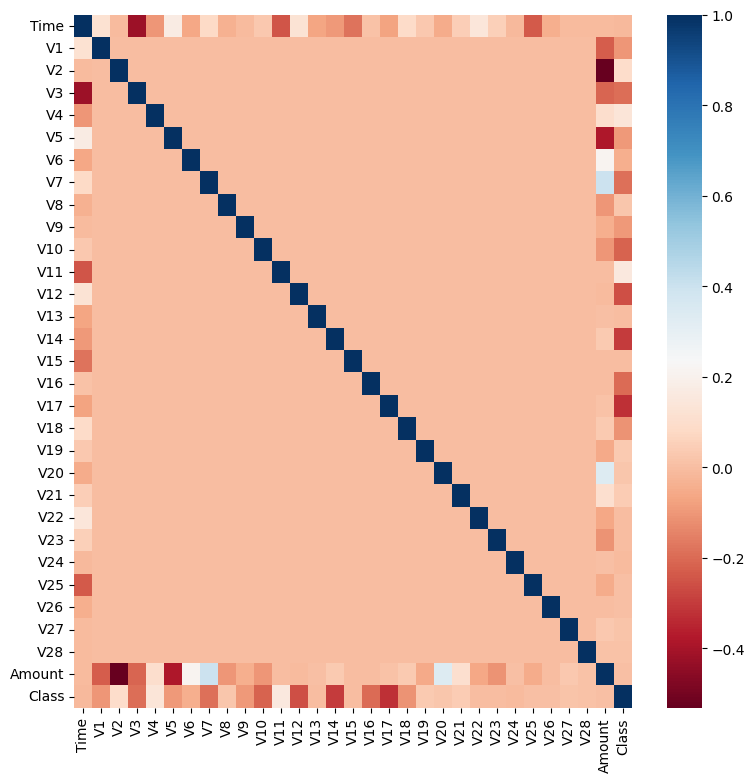

In [ ]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
# get_preprocessed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1: 0.7568, AUC:0.9725
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC:0.9780


#### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 전 레이블 값 분포:\n', pd.Series(y_train).value_counts())
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 전 레이블 값 분포:
 Class
0    199020
1       342
Name: count, dtype: int64
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE로 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1: 0.1022, AUC:0.9736


오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해서 정밀도가 급격히 떨어지게 된 것. 이 정도로 저조한 정밀도로는 현실 업무에 적용 불가.

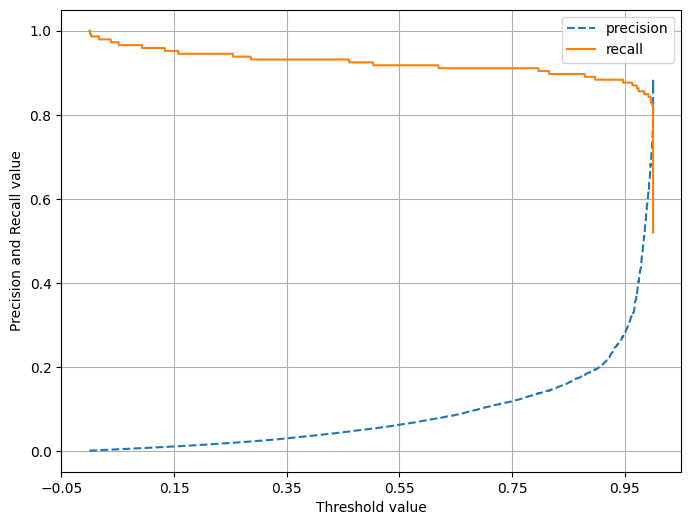

In [ ]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값을 각각 plot으로 수행. 정밀도는 점선으로 표시.
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0: threshold_boundary], label='recall')

  # threshold값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.2),2))

  # X축, Y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값 0.99를 기준으로 재현율이 대폭 떨어지고 정밀도가 극단적으로 높아짐. 분류 결정 임계값을 조정하더라도 임계값의 민감도가
너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로, 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못한다는 결론.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


이처럼 SMOTE를 적용하면 재현율을 높아지나, 정밀도는 낮아지는 것이 일반적임. 그렇기 때문에 정밀도 지표보단 재현율 지표를 높이는 것이 중요한 목표인 경우에 SMOTE를 적용하면 좋음. 좋은 SMOTE 패키지일수록 재현율의 증가율은 높이고 정밀도의 감소율은 낮출 수 있도록 데이터를 효과적으로 증식함.

아래는 데이터를 가공한 방법과 각각의 경우에 로지스틱 회귀와 LightGBM을 적용한 결과를 정리한 표.

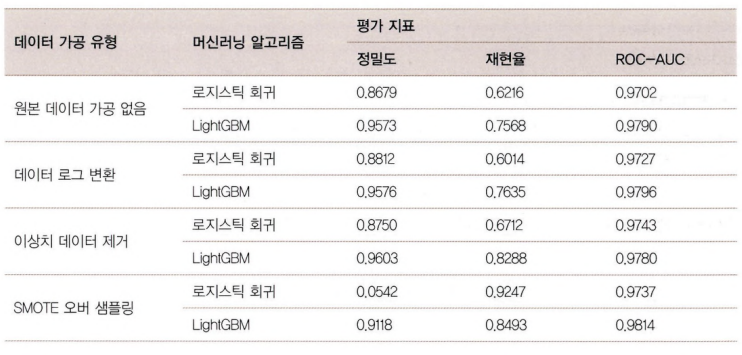